# Appendix — Diagnostics, Ablations, and Learning Curves

Technical deep-dive supporting the main notebook: extended diagnostics, ablations, coefficient checks, and learning curves.

## How to use this appendix

This appendix supports the main results by stress‑testing assumptions and stability.

- Residual Diagnostics: check linearity and constant variance in residuals.
- Test Error Diagnostics: ECDF, top absolute errors, and signed error vs predicted (small n → illustrative only).
- Ablations (OLS subsets): compare feature subsets; flag those within `DECISION_MARGIN` and prefer simpler when tied.
- Learning Curves: when available, show MAE/uncertainty vs sample size; if skipped, more data is needed.
- Coefficient Checks: sanity‑check signs/magnitudes and verify manual reconstruction.
- Reproducibility: library versions for reference.

### Imports

In [34]:
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from IPython.display import display, Markdown
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from utils import (
    SEED as SEED_DEFAULT, N_GRID_DEFAULT, MAPE_THRESHOLD_DEFAULT, DECISION_MARGIN_DEFAULT,
    CV_SPLITS_A_DEFAULT, CV_SPLITS_DEFAULT, CV_REPEATS_DEFAULT, BOOT_B_DEFAULT, FEATURES,
    load_records, validate_records,
    approach_b_ols, approach_b_ridge_cv,
    plot_residuals_vs, ols_ablations,
    learning_curve, plot_learning_curve,
    coef_sanity_checks,
    cv_single_feature, select_best,
)

### Configuration

In [35]:
# Overrides
SEED = SEED_DEFAULT
N_GRID = N_GRID_DEFAULT
DECISION_MARGIN = DECISION_MARGIN_DEFAULT
CV_SPLITS = CV_SPLITS_DEFAULT
CV_REPEATS = CV_REPEATS_DEFAULT
BOOT_B = BOOT_B_DEFAULT

### Load Data and Split

In [36]:
base = Path('..').resolve()
records_path = base / 'output' / 'records.jsonl'
print({'records_path': str(records_path)})

df = load_records(records_path)
df = validate_records(df)
print(df.attrs.get('validation_info', {}))

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

{'records_path': '/Users/peta/Documents/dev/token-approx/output/records.jsonl'}
{'total_before': 25, 'drops': {'input_tokens_na': 0, 'bytes_non_numeric_or_na': 0, 'runes_non_numeric_or_na': 0, 'words_non_numeric_or_na': 0, 'lines_non_numeric_or_na': 0}, 'total_after': 25}


## Residual Diagnostics

Fit OLS on train/test and plot residual diagnostics.

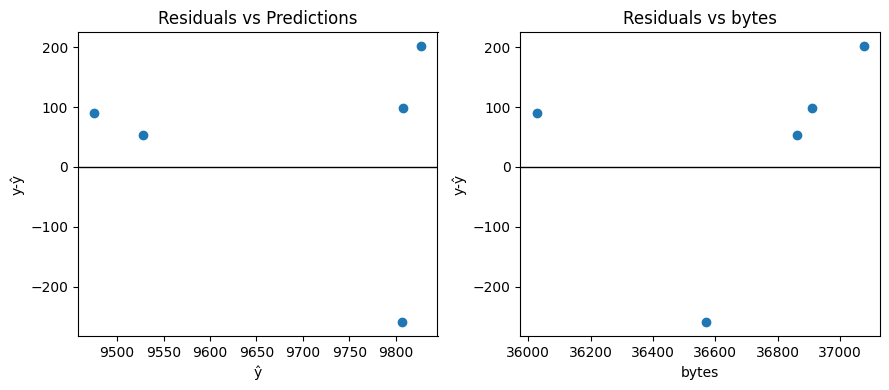

In [37]:
res_b_ols = approach_b_ols(train_df, test_df)

yhat = res_b_ols['pred']
resid = res_b_ols['yte'] - yhat

axes = plot_residuals_vs(yhat, resid, x_series=test_df['bytes'], x_label='bytes')
fig = axes[0].get_figure() if isinstance(axes, np.ndarray) else axes.get_figure()

### Takeaways

- No clear residual pattern on this split; one moderate outlier.
- Sample size on test is small → treat linearity/variance conclusions as tentative.

## Test Error Diagnostics

Detailed test error views supporting the main notebook.

#### Test absolute errors (sorted)

,0,1,2,3,4
abs_err,52.689186,90.815837,99.175154,201.511729,259.278828


#### Test predictions and errors (sorted by abs_err)

,y_true,y_pred,signed_err,abs_err
0,9548,9807.278828,-259.278828,259.278828
1,10029,9827.488271,201.511729,201.511729
2,9907,9807.824846,99.175154,99.175154
3,9566,9475.184163,90.815837,90.815837
4,9580,9527.310814,52.689186,52.689186


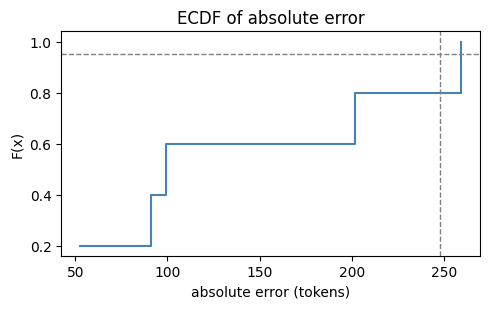

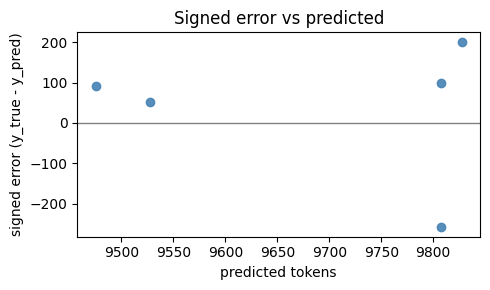

In [38]:
# Use the OLS best subset predictions computed earlier in this appendix
y_true = res_b_ols['yte']
y_pred = res_b_ols['pred']

abs_err = np.abs(y_true - y_pred)
med = float(np.median(abs_err))
p95 = float(np.percentile(abs_err, 95))
mx  = float(np.max(abs_err))
n   = len(abs_err)

err_df = pd.DataFrame({'abs_err': np.sort(abs_err)})
display(Markdown("#### Test absolute errors (sorted)"))
display(err_df.T)

# ECDF
fig, ax = plt.subplots(figsize=(5, 3.2))
xs = np.sort(abs_err)
ys = np.arange(1, n + 1) / n
ax.step(xs, ys, where='post', color='steelblue')
ax.axhline(0.95, ls='--', color='gray', lw=1)
ax.axvline(p95, ls='--', color='gray', lw=1)
ax.set_title('ECDF of absolute error')
ax.set_xlabel('absolute error (tokens)')
ax.set_ylabel('F(x)')
plt.tight_layout()

# Signed error diagnostics (table + scatter)
signed_err = y_true - y_pred
tmp = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'signed_err': signed_err,
    'abs_err': abs_err
}).sort_values('abs_err', ascending=False).reset_index(drop=True)
display(Markdown("#### Test predictions and errors (sorted by abs_err)"))
display(tmp)

fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(y_pred, signed_err, color='steelblue', alpha=0.9)
ax.axhline(0, color='gray', lw=1)
ax.set_xlabel('predicted tokens')
ax.set_ylabel('signed error (y_true - y_pred)')
ax.set_title('Signed error vs predicted')
plt.tight_layout()

### Takeaways
- n=5 test set → indicative only.
- On this split, median and max absolute errors provide a quick sense check; ECDF/table are included for transparency.
- We rely on train‑side repeated‑CV with bootstrap CIs for stability; collect more test samples before drawing distributional conclusions.

## Ablations (OLS Subsets)

Feature configurations are marked as `within_margin` when their MAE is within `DECISION_MARGIN` of the best MAE. Treat those as equivalently good on this dataset; prefer the simpler set unless a larger set gives a clear, robust gain.

In [39]:
# Run OLS ablations and flag within-margin results
features = FEATURES

# All non-empty subsets (size 1..4), ordered by size then lexicographic
CANDIDATES = [
    list(cols)
    for r in range(1, len(features) + 1)
    for cols in combinations(sorted(features), r)
]

abl_results = ols_ablations(train_df, test_df, CANDIDATES)
df_abl = pd.DataFrame(abl_results)
if not df_abl.empty:
    df_abl = df_abl.sort_values('mae').reset_index(drop=True)
    best_mae = df_abl['mae'].iloc[0]

    df_abl['within_margin'] = ((df_abl['mae'] - best_mae) / best_mae) <= DECISION_MARGIN

    def _bold_within_margin(row):
        return ['font-weight: bold' if bool(row['within_margin']) else '' for _ in row]

    styled = df_abl.style.apply(_bold_within_margin, axis=1)
    display(styled)
else:
    print({'ablations': 'no results'})

,cols,mae,bias,intercept,coefs,within_margin
0,"['bytes', 'words']",128.641883,45.734170,-4001.201841,"{'bytes': 0.5758117480861196, 'words': -1.1822491809479783}",True
1,"['bytes', 'runes', 'words']",131.046255,59.904726,-2610.405772,"{'bytes': 0.7328881520666659, 'runes': -0.2381400225536208, 'words': -0.968581204429918}",True
2,"['bytes', 'lines', 'runes', 'words']",140.694147,36.982616,-2789.705253,"{'bytes': 0.4767476275305158, 'lines': 2.0566415368291557, 'runes': -0.005441236064244524, 'words': -1.0124128837863848}",False
3,"['bytes', 'lines', 'words']",140.771939,36.558432,-2808.431922,"{'bytes': 0.472022931321987, 'lines': 2.0793946115798856, 'words': -1.01547003608618}",False
4,"['bytes', 'runes']",153.020134,93.339443,-3149.846818,"{'bytes': 0.8116921631312474, 'runes': -0.4754577744850986}",False
5,['runes'],154.417959,61.949713,-6864.286276,{'runes': 0.4623517853372125},False
6,['bytes'],154.600783,75.950348,-7013.629248,{'bytes': 0.45419970834349976},False
7,"['bytes', 'lines', 'runes']",154.611618,76.195700,-3312.972528,"{'bytes': 0.609438192728638, 'lines': 1.646896792144142, 'runes': -0.297719407260726}",False
8,"['bytes', 'lines']",156.455110,56.226054,-4639.179627,"{'bytes': 0.32704267646165747, 'lines': 3.0520632217181354}",False
9,"['lines', 'runes']",158.185256,33.700029,-4553.863149,"{'lines': 4.990709286666581, 'runes': 0.2928297823240975}",False


### Takeaways

- Best subset on this split: bytes+words.
- bytes+runes+words is within the decision margin (but prefer the simpler set unless a robust gain appears).

## Learning Curves

Learning curves for A (selected single feature) and B (OLS 4 features).

Curves are computed only when `N_GRID` points do not exceed the available training size. When skipped on small datasets, interpret this as "insufficient sample sizes to form a meaningful curve"; with more data, expect MAE to decrease and variance bands to tighten as `n` grows.

In [40]:
features_list = FEATURES
rows = []
for feat in features_list:
    Xtr_feat = train_df[[feat]].to_numpy()
    ytr = train_df['input_tokens'].to_numpy()
    for fi in (False, True):
        mae_cv, bias_cv = cv_single_feature(Xtr_feat, ytr, fit_intercept=fi, n_splits=CV_SPLITS_A_DEFAULT, seed=SEED)
        rows.append({'feature': feat, 'fit_intercept': fi, 'cv_mae': mae_cv, 'cv_bias': bias_cv})
cv_df = pd.DataFrame(rows).sort_values(['cv_mae', 'feature', 'fit_intercept']).reset_index(drop=True)
best_cv = select_best(cv_df)
feat = best_cv['feature']
fi = bool(best_cv['fit_intercept'])

# Pre-filter N_GRID
N_GRID_filtered = [int(n) for n in N_GRID if int(n) <= len(train_df)]
if not N_GRID_filtered:
    print({'learning_curves': 'skipped', 'reason': 'n_grid > len(train_df)', 'len_train_df': int(len(train_df)), 'N_GRID': list(N_GRID)})
    display(Markdown("Learning curves skipped (grid > train size). With more data, expect MAE to decrease and confidence bands to tighten."))
else:
    lc_df = learning_curve(
        train_df,
        n_grid=N_GRID_filtered,
        feature_A=(feat,),
        feature_B=('bytes','runes','words','lines'),
        seed=SEED,
        cv_splits=CV_SPLITS,
        cv_repeats=CV_REPEATS,
        boot_B=BOOT_B,
        fit_intercept_A=fi,
    )
    print({'learning_curve_feature_A': feat, 'fit_intercept_A': fi})

    if lc_df is not None and not lc_df.empty:
        display(lc_df)
        ax = plot_learning_curve(lc_df)
    else:
        print({'learning_curves': 'skipped_or_empty'})

{'learning_curves': 'skipped', 'reason': 'n_grid > len(train_df)', 'len_train_df': 20, 'N_GRID': [25, 40, 60, 80, 100, 120]}


Learning curves skipped (grid > train size). With more data, expect MAE to decrease and confidence bands to tighten.

### Takeaways

- Curves skipped due to small train size; with more data, expect MAE to decrease and bands to tighten.

## Coefficient Checks

Sanity flags on best B model and coefficient recovery demos.

In [41]:
# Coefficient checks using OLS best-subset (from ablations if available)
from itertools import combinations
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Determine best subset
best_cols = None
best_res = None

# Prefer the ablations table if it exists
if 'df_abl' in globals() and isinstance(df_abl, pd.DataFrame) and not df_abl.empty:
    best_cols = df_abl.loc[0, 'cols'] if 'cols' in df_abl.columns else None

# Fallback: recompute best subset by test MAE
if best_cols is None:
    features = FEATURES
    best_mae = np.inf
    for r in range(1, len(features) + 1):
        for cols in combinations(sorted(features), r):
            Xtr = train_df[list(cols)].to_numpy()
            ytr = train_df['input_tokens'].to_numpy()
            Xte = test_df[list(cols)].to_numpy()
            yte = test_df['input_tokens'].to_numpy()
            lr = LinearRegression(fit_intercept=True)
            lr.fit(Xtr, ytr)
            pte = lr.predict(Xte)
            mae = float(np.mean(np.abs(yte - pte)))
            if mae < best_mae:
                best_mae = mae
                best_res = {
                    'cols': list(cols),
                    'intercept': float(lr.intercept_),
                    'coefs': dict(zip(list(cols), map(float, lr.coef_))),
                    'pred': pte,
                }
    best_cols = best_res['cols']
    intercept = best_res['intercept']
    coefs = best_res['coefs']
    pred = best_res['pred']
else:
    # Refit on best_cols to capture exact coefficients and predictions
    Xtr = train_df[best_cols].to_numpy()
    ytr = train_df['input_tokens'].to_numpy()
    Xte = test_df[best_cols].to_numpy()
    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xtr, ytr)
    pred = lr.predict(Xte)
    intercept = float(lr.intercept_)
    coefs = dict(zip(best_cols, map(float, lr.coef_)))

print({'best_subset_cols': best_cols})

# Sanity flags and manual reconstruction
flags = coef_sanity_checks(coefs)
print({'ols_subset_flags': flags})

coef_order = sorted(coefs.keys())
Xte = test_df[coef_order].to_numpy()
coef_vec = np.array([coefs[k] for k in coef_order], dtype=float)
manual_pred = intercept + Xte @ coef_vec
ok = np.allclose(manual_pred, pred, atol=1e-6)
max_diff = float(np.max(np.abs(manual_pred - pred)))
print({'ols_subset_coef_recovery_check': bool(ok), 'max_abs_diff': max_diff})

{'best_subset_cols': ['bytes', 'words']}
{'ols_subset_flags': {'negative_bytes': False, 'negative_runes': False, 'notes': []}}
{'ols_subset_coef_recovery_check': True, 'max_abs_diff': 0.0}


### Takeaways

- Sanity flags are clear; manual reconstruction matches predictions.
- Linear model behavior verified on this split.

## Reproducibility

Library versions for reference (see below).

In [42]:
display(Markdown(f"""Library versions:\n{'\n'.join([f'- {k}: {v}' for k, v in {'numpy': np.__version__, 'pandas': pd.__version__, 'sklearn': sklearn.__version__}.items()])}"""))

Library versions:
- numpy: 2.3.4
- pandas: 2.3.3
- sklearn: 1.7.2